# HW1 - Bobrovskikh Gleb

In this notebook we handle the homework data in order to predict motion over rest using EEG.

Target is **condition** column, which can be described as 1 -- resting state, 2 and 3 -- hand motions. In the prediction 0 (zero) values should correspond to resting state, and 1 (ones) -- to motion. 

In [1]:
# For Colab only
# !pip install mne
# !wget https://raw.githubusercontent.com/adasegroup/NEUROML2020/seminar1/seminar1/train.csv
# !wget https://raw.githubusercontent.com/adasegroup/NEUROML2020/seminar1/seminar1/test.csv

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import mne
from mne.time_frequency import psd_array_multitaper

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE

%matplotlib inline

In [12]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [13]:
df_train.head()

,time,condition,epoch,C3,Cz,C4,Fp1,Fp2,F7,F3,...,F8,T7,T8,P7,P3,Pz,P4,P8,O1,O2
0,0,1,0,-5.885714,-2.533107,9.866895,7.962973,5.694433,23.638605,27.899784,...,23.588723,12.178548,0.685809,-4.887397,-10.646985,-14.735646,-8.729323,-0.562578,-17.055458,-3.616732
1,1,1,0,-7.999715,-16.916729,-11.924855,17.955477,8.526994,56.635981,28.508435,...,1.045533,14.656061,-4.119778,-4.632381,-17.980657,-23.456960,-12.960684,-9.639784,-20.233549,-1.229811
2,2,1,0,-6.727283,-15.979567,-11.114195,17.183478,4.497028,43.914130,10.079754,...,-14.741630,14.793562,-6.624813,-3.402757,-10.269473,-18.736144,-3.579046,-0.045658,-14.089755,2.453398
3,3,1,0,6.819390,-0.204905,10.090124,20.265222,7.843006,36.250611,13.291199,...,-7.135541,21.723418,-2.276825,2.066859,4.325365,-2.803322,8.835114,13.878945,-5.772410,7.657873
4,4,1,0,13.129486,-5.817193,5.040633,19.462210,9.634234,42.311729,20.641012,...,0.015602,19.703190,3.739076,2.714350,3.251047,-3.631448,3.212956,4.635574,-5.045448,5.086024


In [14]:
ch_names = df_train.columns[3:]
print(ch_names)

Index(['C3', 'Cz', 'C4', 'Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T7',
       'T8', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'O2'],
      dtype='object')


In [338]:
sorted('FP1 FP2 F3 F4 C3 C4 P3 P4 O1 O2 F7 F8 T3 T4 T5 T6 FZ CZ PZ'.split(' ')), sorted(list(ch_names))

(['C3',
  'C4',
  'CZ',
  'F3',
  'F4',
  'F7',
  'F8',
  'FP1',
  'FP2',
  'FZ',
  'O1',
  'O2',
  'P3',
  'P4',
  'PZ',
  'T3',
  'T4',
  'T5',
  'T6'],
 ['C3',
  'C4',
  'Cz',
  'F3',
  'F4',
  'F7',
  'F8',
  'Fp1',
  'Fp2',
  'Fz',
  'O1',
  'O2',
  'P3',
  'P4',
  'P7',
  'P8',
  'Pz',
  'T7',
  'T8'])

In [15]:
epochs = df_train['epoch'].unique()
print(epochs)

[  0   2   6   8  11  13  15  16  17  18  19  20  21  22  23  24  25  26
  29  30  31  32  33  34  36  37  38  39  42  43  44  46  47  48  49  50
  51  52  53  54  55  56  58  60  61  62  64  65  66  67  68  69  74  77
  79  80  81  86  87  88  89  90  91  93  95  96  97  99 101 102 105 107
 109 110 111 113 115 117 118 126 127 128 129 131 134 135 136 137 138 139
 141 142 143 144 145 147 151 152 154 155 156 157 158 159 160 162 164 166
 167 169 171 172 173 174 175 176 177 181 182 184 185 187 192 193 194 196
 197 200 201 202 204 205 210 212 216 217 221 222 223 225 226 227 228 230
 231 233 234 235 237 239 240 241 244 245 246 248 250 253 254 255 261 262
 263 265 268 269 270 276 277 279 281 283 285 287 290 292 293 294 297 298]


In [16]:
conditions = df_train['condition'].unique()
print(conditions)

[1 2 3]


In [17]:
def get_target(df):
    return df.drop_duplicates('epoch')[['epoch', 'condition']].reset_index(drop=True)

In [18]:
respond_epoches = df_train[df_train['condition'] != 1]['epoch'].unique()
rest_epoches = df_train[df_train['condition'] == 1]['epoch'].unique()

In [334]:
len(df_train[df_train['epoch'] == 6]) / 160

0.50625

## Feature engineering

Creating RawArray with float64 data, n_channels=19, n_times=14580
    Range : 0 ... 14579 =      0.000 ...    91.119 secs
Ready.


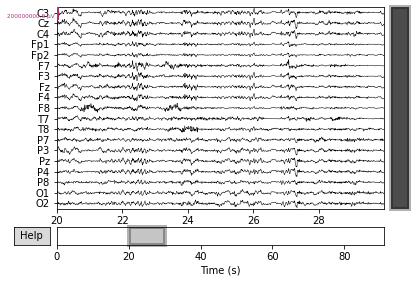

In [23]:
raw_eeg_data = df_train[ch_names].to_numpy().T # shape (19, 14580)
data_mne = mne.io.RawArray(raw_eeg_data, info=mne.create_info(ch_names.to_list(), 160, ch_types='eeg'))
data_mne.plot(start=20, duration=10, scalings={'eeg': 100});

Effective window size : 12.800 (s)


<ipython-input-24-e9844a2d7f20>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  data_mne.plot_psd();


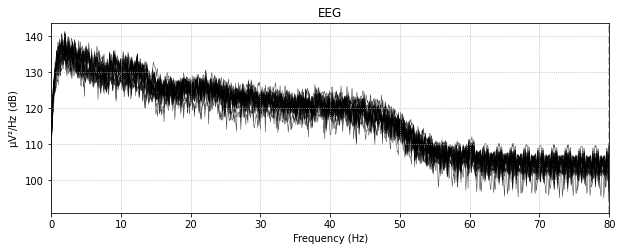

In [24]:
data_mne.plot_psd();

### Band-filtering MNE

Keep only frequencies that are typical for human EEG: 0.5–40 Hz;

In [25]:
from mne.filter import filter_data#, notch_filter

In [26]:
filtered_df = filter_data(df_train[ch_names].T, sfreq=160, l_freq=.5, h_freq=40, method='iir')
filtered_df = pd.DataFrame(filtered_df.T, columns=ch_names)
filtered_df[['epoch', 'condition','time']] = df_train[['epoch', 'condition','time']]

Setting up band-pass filter from 0.5 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 40.00 Hz: -6.02, -6.02 dB



Creating RawArray with float64 data, n_channels=19, n_times=14580
    Range : 0 ... 14579 =      0.000 ...    91.119 secs
Ready.


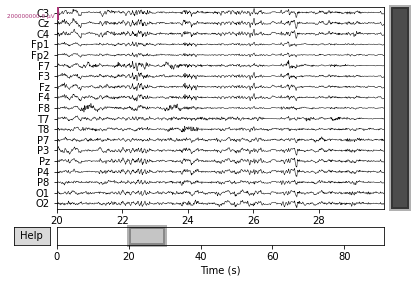

In [27]:
data_mne_filtered = mne.io.RawArray(filtered_df[ch_names].to_numpy().T, info=mne.create_info(ch_names.to_list(), 160, ch_types='eeg'))
data_mne_filtered.plot(start=20, duration=10, scalings={'eeg': 100});


Effective window size : 12.800 (s)


<ipython-input-28-2ea10071d503>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  data_mne_filtered.plot_psd();


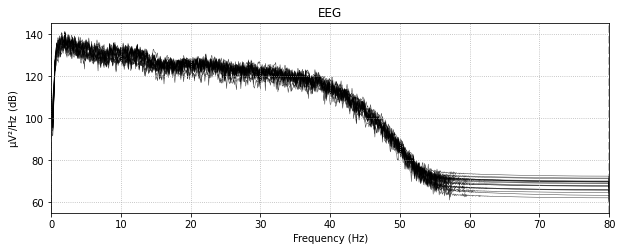

In [28]:
data_mne_filtered.plot_psd();

Effective window size : 12.800 (s)


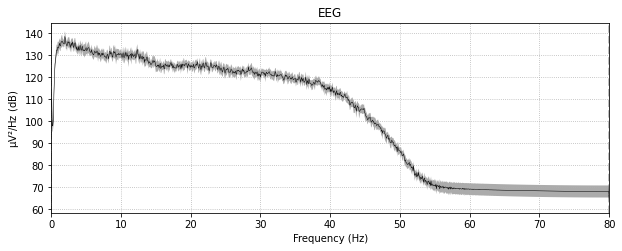

In [29]:
data_mne_filtered.plot_psd(average=True);

### Resting epochs pre-filtering and post-filtering

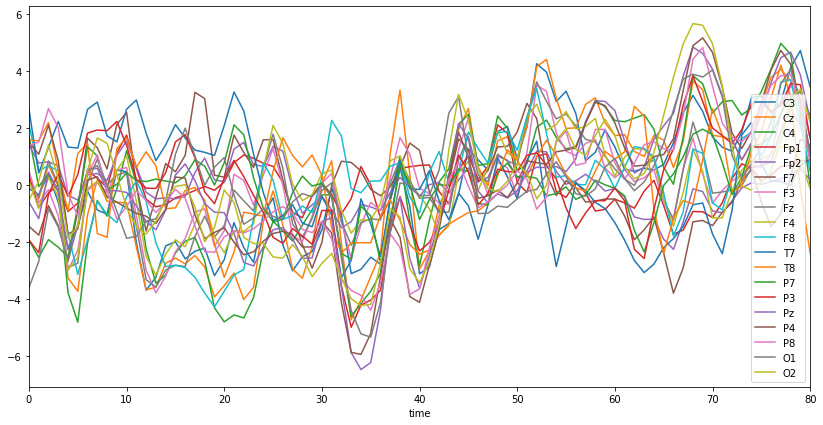

In [30]:
df_train[df_train['condition'] == 1].groupby('time')[ch_names].mean().plot(figsize=(14, 7))

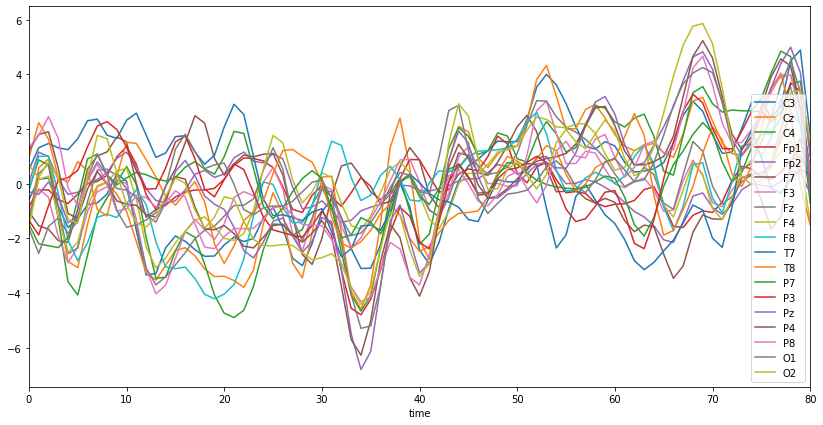

In [31]:
filtered_df[df_train['condition'] == 1].groupby('time')[ch_names].mean().plot(figsize=(14, 7))

### Respond epochs pre-filtering and post-filtering

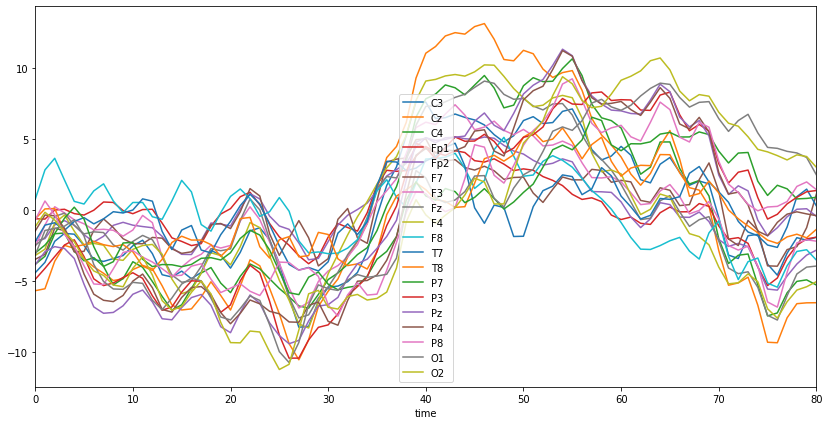

In [32]:
df_train[df_train['condition'] != 1].groupby('time')[ch_names].mean().plot(figsize=(14, 7))

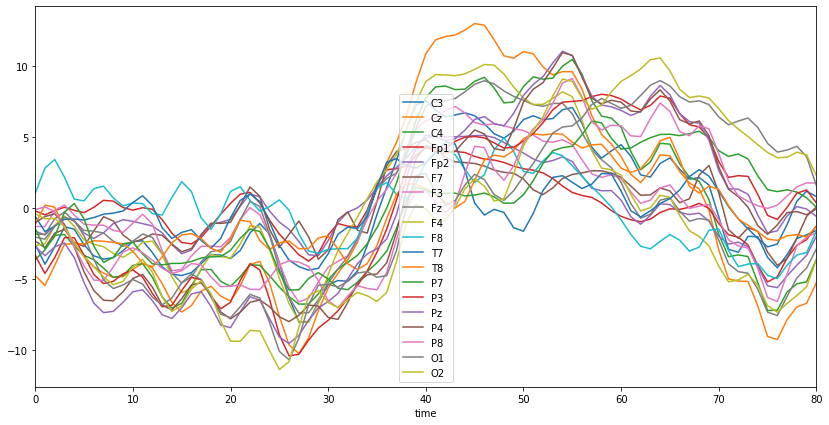

In [33]:
filtered_df[df_train['condition'] != 1].groupby('time')[ch_names].mean().plot(figsize=(14, 7))

### Some plots

In [34]:
def plot_psd(df, label='psd'):
    psds, freqs = psd_array_multitaper(df[ch_names].T.values, 160, verbose=False)

    psds = 10 * np.log10(psds)
    psds_mean = psds.mean(0)
    psds_std = psds.std(0)

    plt.plot(freqs, psds_mean, label=label)
    plt.fill_between(freqs, psds_mean - psds_std, psds_mean + psds_std, alpha=.5)
    plt.grid('on')
    plt.legend()
    

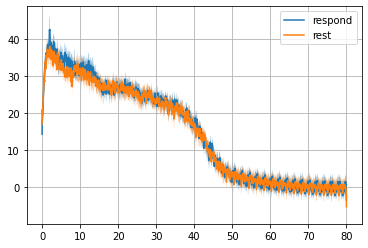

In [35]:
plot_psd(filtered_df[filtered_df['condition']!= 1][ch_names], label='respond')
plot_psd(filtered_df[filtered_df['condition']== 1][ch_names], label='rest')


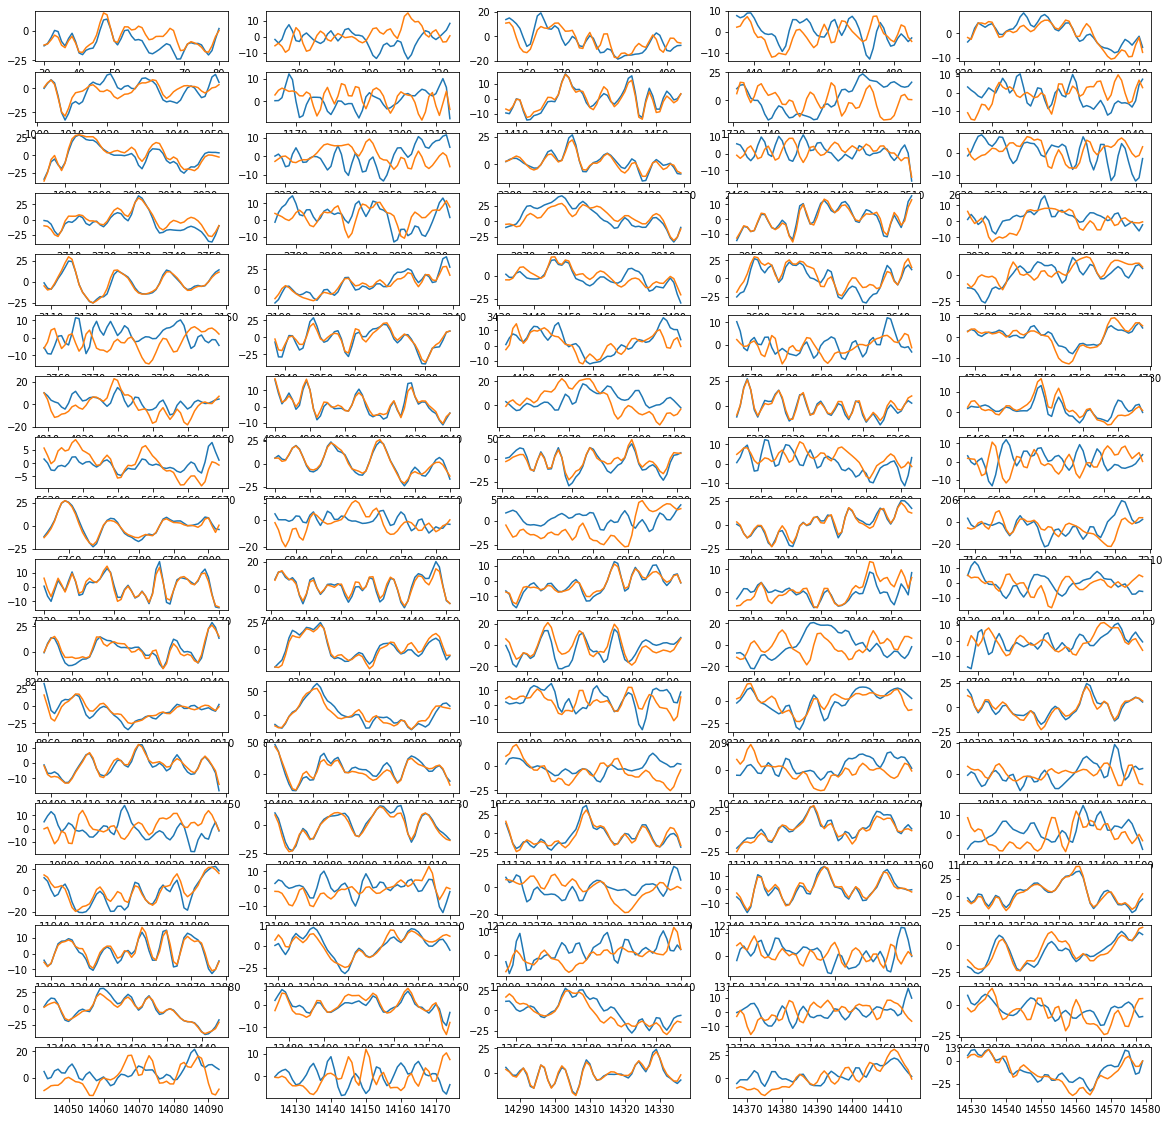

In [36]:
fig, axs = plt.subplots(18, 5, figsize=(20, 20))
for ax, epoch in zip(axs.ravel(), rest_epoches):
    ax.plot(filtered_df[filtered_df['epoch'] == epoch].iloc[30:][['Fp1', 'Fp2']])
    

In [37]:
data_mne_alpha = data_mne_filtered.copy().filter(l_freq=7, h_freq=13, method='iir', verbose=False).apply_hilbert(envelope=True)

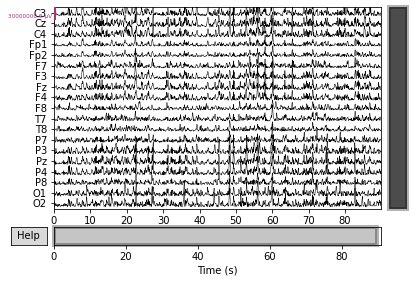

In [38]:
data_mne_alpha.plot(duration=90, scalings={'eeg': 15});

In [39]:
data_mne_beta = data_mne_filtered.copy().filter(l_freq=13, h_freq=20, method='iir', verbose=False).apply_hilbert(envelope=True)

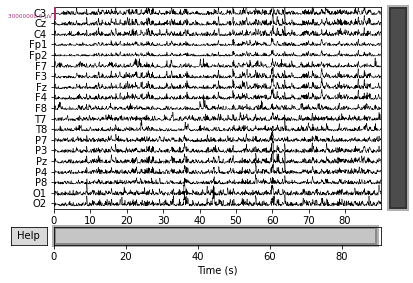

In [40]:
data_mne_beta.plot(duration=90, scalings={'eeg': 15});

### ICA

In [27]:
from mne.preprocessing import ICA

Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 10 components


/var/folders/gm/4vcpcg711mb8scmdxsq54rfr0000gn/T/ipykernel_85716/394079754.py:2: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(data_mne_filtered)


Fitting ICA took 0.4s.
Creating RawArray with float64 data, n_channels=10, n_times=14580
    Range : 0 ... 14579 =      0.000 ...    91.119 secs
Ready.


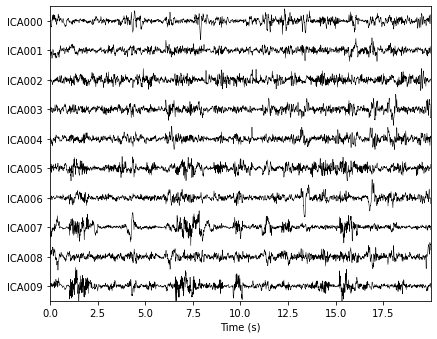

In [29]:
ica = ICA(n_components=10, method='picard', max_iter='auto', random_state=42)
ica.fit(data_mne_filtered)
ica.plot_sources(data_mne_filtered, show_scrollbars=False);

### Calculate features

Feature description:
- power of EEG bands:
    - delta
    - alpha
    - beta
    - theta
- p300
- statistics:
    - mean
    - std
    - skew
    - kurtosis
    - zero-crossings
    - absolute area under signal curve
    - peak to peak
    

In [41]:
from scipy.stats import kurtosis, skew

In [42]:
def calc_features(df):
    feats = []
    filtered_df = filter_data(df[ch_names].T, sfreq=160, l_freq=0.5, h_freq=40)
    filtered_df = pd.DataFrame(filtered_df.T, columns=ch_names)
    filtered_df[['epoch', 'time']] = df[['epoch', 'time']]
    for epoch_idx, epoch_df in filtered_df.groupby('epoch'):

        epoch_df = epoch_df[ch_names]

        psds, freqs = psd_array_multitaper(epoch_df.T.values, 160, verbose=False)

        total_power = psds.sum(axis=1)
        pwrs = {'delta': [.5, 4],
                'alpha': [13, 25], 
                'beta': [7, 13], 
                'theta': [3, 8]}
        pwrs_vals = {}
        for pwr_name, (val1, val2) in pwrs.items():
            # eeg band power rate
            idx_from = np.where(freqs > val1)[0][0]
            idx_to = np.where(freqs > val2)[0][0]
            pwr = psds[:,idx_from:idx_to].sum(axis=1) / total_power
            pwrs_vals[pwr_name] = pwr
        
        d = {}
        d['epoch'] = epoch_idx

        for i, ch in enumerate(ch_names):
            # p300
            s = epoch_df.iloc[40:][ch]
            val = (s > 5).sum()
            d[ch.lower() + '_p300'] = val
            # statistics
            d[ch.lower() + '_mean'] = epoch_df[ch].mean()
            d[ch.lower() + '_std'] = epoch_df[ch].std()
            d[ch.lower() + '_skew'] = skew(epoch_df[ch])
            d[ch.lower() + '_kurtosis'] = kurtosis(epoch_df[ch])
            d[ch.lower() + '_zero_crossings'] = len(np.where(np.diff(np.sign(epoch_df[ch])))[0])
            d[ch.lower() + '_abs_area'] = np.trapz(abs(epoch_df[ch]))
            d[ch.lower() + '_p2p'] = np.max(epoch_df[ch]) - np.min(epoch_df[ch])
            # frequencies
            for pwr_name, val in pwrs_vals.items():
                d[ch.lower() + f'_{pwr_name}_pwr'] = pwrs_vals[pwr_name][i]
            
            
            
        feats.append(d)
        
    feats_df = pd.DataFrame(feats)
    
    return feats_df

In [43]:
X = get_target(df_train)
X = X.merge(calc_features(df_train), on='epoch')
y = X['condition'].apply(lambda x: 0 if x == 1 else 1)
del X['epoch']
del X['condition']

Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1057 samples (6.606 sec)



In [44]:
X

,c3_abs_area,c3_alpha_pwr,c3_beta_pwr,c3_delta_pwr,c3_kurtosis,c3_mean,c3_p2p,c3_p300,c3_skew,c3_std,...,t8_beta_pwr,t8_delta_pwr,t8_kurtosis,t8_mean,t8_p2p,t8_p300,t8_skew,t8_std,t8_theta_pwr,t8_zero_crossings
0,1549.191512,0.077731,0.209584,0.381343,-0.198245,4.681295,113.182842,12,0.116467,23.625458,...,0.177913,0.266968,0.539898,-0.444393,49.549459,8,-0.319971,9.553298,0.322433,26
1,801.487699,0.048171,0.244222,0.426519,-0.213083,2.506515,54.541679,20,0.822475,13.157874,...,0.243976,0.369513,-0.618292,-0.096116,63.762112,19,0.364844,14.966674,0.378975,8
2,331.361081,0.375390,0.121882,0.152274,-0.335441,0.886774,24.075868,9,-0.166887,4.956504,...,0.216727,0.260046,-0.030554,-0.006394,74.538815,10,0.551505,15.846141,0.318327,17
3,353.895396,0.140131,0.263857,0.264210,-0.044072,0.023567,27.032485,9,0.345262,5.614492,...,0.172422,0.140708,-0.556690,0.274740,59.014537,10,0.156326,13.921011,0.189663,16
4,827.647252,0.147432,0.211438,0.347282,-0.827453,-0.222915,50.300328,7,0.014879,12.339902,...,0.229876,0.429785,-0.453264,0.221639,42.246273,8,0.190170,10.137769,0.461446,7
5,696.665757,0.231886,0.257718,0.193982,2.554983,-0.143270,77.560991,9,-0.500873,12.195678,...,0.213487,0.286238,-0.479072,0.319781,33.975564,4,-0.197656,7.769886,0.348183,19
6,601.770119,0.304390,0.190071,0.128821,-0.137102,0.198645,46.438975,11,-0.119172,9.327850,...,0.122813,0.162640,0.148415,0.335147,46.597867,15,-0.191397,9.101894,0.190884,21
7,1134.618001,0.179661,0.304926,0.242458,-0.956341,0.171101,66.522817,9,0.206882,16.628236,...,0.234441,0.209689,-0.328862,0.264697,64.296739,11,0.244418,13.367422,0.285424,12
8,1839.028608,0.058376,0.324990,0.337856,-0.259110,0.354136,118.619150,20,0.489798,29.466585,...,0.316072,0.336669,1.014086,0.136651,91.682054,19,0.916131,18.296525,0.405362,14
9,1279.665576,0.125269,0.219108,0.347125,-0.344450,0.220373,84.161322,20,0.443208,19.961337,...,0.212074,0.319999,-0.506690,-0.024124,41.608694,17,-0.421593,9.692837,0.394987,12


## Visualize t-SNE

In [45]:
X_embedded = TSNE(n_components=2).fit_transform(X)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/extmath.py:151: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


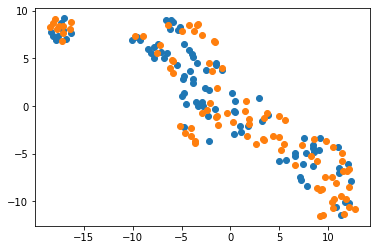

In [46]:
plt.scatter(X_embedded[np.where(y == 0), 0], X_embedded[np.where(y == 0), 1])
plt.scatter(X_embedded[np.where(y == 1), 0], X_embedded[np.where(y == 1), 1])

## ML workflow

In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [48]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [49]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold

#### Random Forest

In [96]:
def gridsearch(clf, parameters, n_splits=3):
    print(f'GRIDSEARCH {clf()}')
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    clf_best = GridSearchCV(clf(), param_grid=parameters, cv=cv,
                       scoring = 'roc_auc', n_jobs=-1)
    clf_best.fit(X_train_sc, y_train)
    print('BEST PARAMS', 
      clf_best.best_params_)
    y_pred_train = clf_best.predict_proba(X_train_sc)[:, 1]
    print(f'Train ROC-AUC: {roc_auc_score(y_train, y_pred_train)}')
    y_pred = clf_best.predict_proba(X_test_sc)[:, 1]
    print(f'Test ROC-AUC: {roc_auc_score(y_test, y_pred)}')
    
    return clf_best.best_params_

In [97]:
parameters = {
    'n_estimators': [10, 20, 50, 70, 100, 120, 300],
    'max_depth': [9, 11, 13, 15, 17, 50],
    'min_samples_split': [2, 10, 100],
    'random_state': [42]
}
rndf_best = gridsearch(RandomForestClassifier, parameters)

GRIDSEARCH RandomForestClassifier()
BEST PARAMS {'max_depth': 9, 'min_samples_split': 10, 'n_estimators': 300, 'random_state': 42}
Train ROC-AUC: 1.0
Test ROC-AUC: 0.6504524886877828


In [99]:
extrarndf_best = gridsearch(ExtraTreesClassifier, parameters)

GRIDSEARCH ExtraTreesClassifier()
BEST PARAMS {'max_depth': 11, 'min_samples_split': 2, 'n_estimators': 300, 'random_state': 42}
Train ROC-AUC: 1.0
Test ROC-AUC: 0.7171945701357466


#### Boosting

In [115]:
parameters = {
    'n_estimators': [50, 100, 120, 300, 500],
    'max_depth': [1, 3, 5, 10, 50],
    'min_samples_split': [2, 10, 100],
    'learning_rate': [0.001, 0.01, 0.1, 0.5],
    'random_state': [42]
}
aboost_best = gridsearch(GradientBoostingClassifier, parameters)

GRIDSEARCH GradientBoostingClassifier()
BEST PARAMS {'learning_rate': 0.5, 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 500, 'random_state': 42}
Train ROC-AUC: 1.0
Test ROC-AUC: 0.6447963800904978


#### SVM

In [101]:
parameters = {
    'C': [.5, .8, 1.0],
    'kernel': ['linear', 'rbf'],
    'probability': [True],
    'random_state': [42]
}

svc_best = gridsearch(SVC, parameters)

GRIDSEARCH SVC()
BEST PARAMS {'C': 1.0, 'kernel': 'rbf', 'probability': True, 'random_state': 42}
Train ROC-AUC: 0.9874441964285714
Test ROC-AUC: 0.670814479638009


#### MLP Neural Network

In [142]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

seed_value=42
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn. benchmark = False

In [440]:
class EEGData(Dataset):

    def __init__(self, X, y):
        self.X = X.astype(np.float)
        self.y = y.to_numpy().astype(np.float)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        return torch.FloatTensor(self.X[i]), torch.LongTensor([self.y[i]])

In [441]:
class MLP(nn.Module):
    def __init__(self, in_feat):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_feat, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(16, 2)
        )
        
    def forward(self, x):
        return self.layers(x)
    
def epoch_train(net, train_loader, opt, criterion):
    avg_train_acc = 0
    avg_train_loss = 0
    net.train()
    for i, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = labels.to(device)

        opt.zero_grad()
        outputs = net(data)

        loss = criterion(outputs, labels.reshape(-1))
        loss.backward()
        opt.step()

        avg_train_loss += loss.cpu().item()
        predicted = outputs.argmax(1)
        avg_train_acc += (predicted == labels.reshape(-1)).float().sum().item()

    avg_train_loss /= len(train_loader)
    avg_train_acc /= len(train_loader.dataset)
    
    return avg_train_loss, avg_train_acc

def epoch_test(net, test_loader, criterion):
    avg_test_loss = 0
    avg_test_acc = 0
    net.eval()
    with torch.no_grad():
        for i, (data, labels) in enumerate(test_loader):
            data = data.to(device)
            labels = labels.to(device)

            outputs = net(data)

            loss = criterion(outputs, labels.reshape(-1))

            avg_test_loss += loss.cpu().item()
            predicted = outputs.argmax(1)
            avg_test_acc += (predicted == labels.reshape(-1)).float().sum().item()

    avg_test_loss /= len(test_loader)
    avg_test_acc /= len(test_loader.dataset)
    
    return avg_test_loss, avg_test_acc

def train(net, train_loader, test_loader, epochs=10):
    criterion = nn.CrossEntropyLoss()
    opt = optim.Adam(params=net.parameters(), lr=0.0001)
    net.to(device)
    print(f'Optimizer {opt}, criterion {criterion}')
    for epoch in range(epochs):
        # train epoch
        avg_train_loss, avg_train_acc = epoch_train(net, train_loader, opt, criterion)
        
        #test epoch
        avg_test_loss, avg_test_acc = epoch_test(net, test_loader, criterion)
        
        print(f'[Epoch {epoch + 1}] train loss: {avg_train_loss:.3f}; train acc: {avg_train_acc:.2f}; ' + 
              f'test loss: {avg_test_loss:.3f}; test acc: {avg_test_acc:.2f}')

In [442]:
# X = get_target(df_train)
# X = X.merge(calc_features(df_train), on='epoch')
# y = X['condition'].apply(lambda x: 0 if x == 1 else 1)
# del X['epoch']
# del X['condition']
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.33, random_state=42)

# scaler = StandardScaler()
# X_train_sc = scaler.fit_transform(X_train)
# X_test_sc = scaler.transform(X_test)

train_set = EEGData(X_train_sc, y_train)
val_set = EEGData(X_test_sc, y_test)

net = MLP(in_feat=X_train_sc.shape[1])

In [443]:
batch_sz = 1
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_sz,
                                         shuffle=False, num_workers=2)

val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_sz,
                                         shuffle=False, num_workers=2)

In [444]:
len(train_loader)

120

In [445]:
train(net, train_loader, val_loader, epochs=100)

Optimizer Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
), criterion CrossEntropyLoss()
[Epoch 1] train loss: 0.707; train acc: 0.41; test loss: 0.693; test acc: 0.48
[Epoch 2] train loss: 0.692; train acc: 0.53; test loss: 0.693; test acc: 0.40
[Epoch 3] train loss: 0.702; train acc: 0.48; test loss: 0.693; test acc: 0.52
[Epoch 4] train loss: 0.702; train acc: 0.48; test loss: 0.693; test acc: 0.48
[Epoch 5] train loss: 0.698; train acc: 0.52; test loss: 0.693; test acc: 0.48
[Epoch 6] train loss: 0.695; train acc: 0.53; test loss: 0.695; test acc: 0.45
[Epoch 7] train loss: 0.694; train acc: 0.53; test loss: 0.694; test acc: 0.45
[Epoch 8] train loss: 0.689; train acc: 0.57; test loss: 0.694; test acc: 0.45
[Epoch 9] train loss: 0.689; train acc: 0.55; test loss: 0.693; test acc: 0.47
[Epoch 10] train loss: 0.690; train acc: 0.50; test loss: 0.693; test acc: 0.48
[Epoch 11] train loss: 0.688; train acc: 0.62; te

In [446]:
ch_names

Index(['C3', 'Cz', 'C4', 'Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T7',
       'T8', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'O2'],
      dtype='object')

#### I also tried to add augmentations (though it didn't improve the score) and this experiment you can find in the notebook Bobrovskikh_HW1_augmentations


## Build submission

In [120]:
scaler = StandardScaler()
X_sc = scaler.fit_transform(X)

In [124]:
clf = ExtraTreesClassifier(**extrarndf_best)

In [125]:
clf.fit(X_sc, y)

ExtraTreesClassifier(max_depth=11, min_samples_split=10, n_estimators=300,
                     random_state=42)

In [126]:
X_test = calc_features(df_test)
submission = X_test[['epoch']].copy()
del X_test['epoch']
X_test_sc = scaler.transform(X_test)

Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1057 samples (6.606 sec)



In [127]:
y_pred = clf.predict_proba(X_test_sc)[:, 1]

In [128]:
submission['Predicted'] = y_pred

In [129]:
submission['Id'] = submission['epoch']
del submission['epoch']

In [130]:
submission.to_csv('extratree_morefeatures_submission_bobrovskikh.csv', index=False)

#### Best submission with ~0.75 score